In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501.xlsx


In [2]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [5]:
# 시간 데이터 변환
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])
df['Pump-End'] = pd.to_datetime(df['Pump-End'])

# 시간 단위 인덱스 설정 (시작 시간 기준)
df.set_index('Pump-Begin', inplace=True)

In [4]:
# PM2.5 질량농도와 금속농도 컬럼 생성
pm25_col = 'Conc(ug/m3)'
metal_cols = [col for col in df.columns if '(ng/m3)' in col]

In [6]:
df_clean = df.copy()

# 숫자형 변환 및 나머지 Nah 변환
df_clean[pm25_col] = pd.to_numeric(df_clean[pm25_col], errors='coerce')
for metal in metal_cols:
    df_clean[metal] = pd.to_numeric(df_clean[metal], errors='coerce')

# 음수값 Nah 처리
df_clean[pm25_col] = df_clean[pm25_col].apply(lambda x: x if x >= 0 else None)
for metal in metal_cols:
    df_clean[metal] = df_clean[metal].apply(lambda x: x if x >= 0 else None)

# 극단값 처리 (평균 ± 3표준편차)
for col in [pm25_col] + metal_cols:
    mean_val = df_clean[col].mean()
    std_val = df_clean[col].std()
    df_clean[col] = df_clean[col].apply(lambda x: x if (mean_val - 3*std_val <= x <= mean_val + 3*std_val) else None)

df_clean.head()

,Pump-End,MassResetTime,Number-of-Split,Analysis-Id,Alarms,ElemError,Mass(ug),Conc(ug/m3),BP_Mass(ugC),BP_Conc(ugC/m3),...,Cd(ng/m3),In(ng/m3),Sn(ng/m3),Sb(ng/m3),Te(ng/m3),Cs(ng/m3),Ba(ng/m3),Ce(ng/m3),Pb(ng/m3),Bi(ng/m3)
Pump-Begin,,,,,,,,,,,,,,,,,,,,,
2025-01-10 10:53:43,2025-01-10 12:00:00,2025-01-10 12:00:00,0,NaN,0x0004000000000000,0x4000000000000000,-22.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-10 12:00:00,2025-01-10 13:00:00,2025-01-10 13:00:00,0,2917.0,0x0000000000000000,0x0000000000000000,-19.7,NaN,NaN,NaN,...,316.97,57.61,30.11,29.99,5.94,NaN,0.0,NaN,16.83,6.62
2025-01-10 13:00:00,2025-01-10 14:00:00,2025-01-10 14:00:00,0,2918.0,0x0000000000000000,0x0000000000000000,10.1,10.20,NaN,NaN,...,313.15,69.71,NaN,NaN,28.56,NaN,0.0,NaN,13.57,NaN
2025-01-10 14:00:01,2025-01-10 15:00:00,2025-01-10 15:00:00,0,2919.0,0x0000000000000000,0x0000000000000000,6.9,6.90,NaN,NaN,...,292.73,54.34,6.92,28.12,47.94,NaN,0.0,NaN,16.47,8.02
2025-01-10 15:00:00,2025-01-10 16:00:00,2025-01-10 16:00:00,0,2920.0,0x0000000000000000,0x0000000000000000,6.2,6.26,NaN,NaN,...,347.83,55.92,23.70,24.88,23.03,NaN,0.0,NaN,2.43,7.10


/tmp/ipython-input-1307037163.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


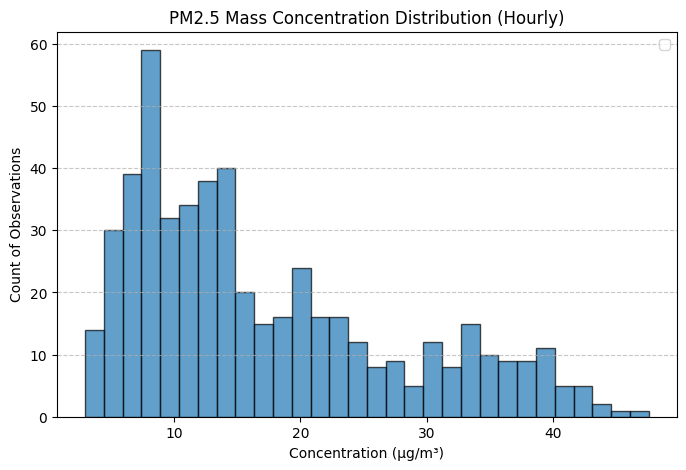

In [7]:
import numpy as np

data = df['Conc(ug/m3)'].dropna()

plt.figure(figsize=(8,5))
n, bins, patches = plt.hist(data[data >= 0], bins=30, edgecolor='black', alpha=0.7)  # 음수 제거 후 bins=30

plt.title('PM2.5 Mass Concentration Distribution (Hourly)')
plt.xlabel('Concentration (µg/m³)')
plt.ylabel('Count of Observations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()